Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood. 

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating). 

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so, similar to  great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily. 

 Footnotes: 
-	You can add or combine steps if needed
-	Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
- Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz 

In [278]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in

import os
os.listdir()
print(os.getcwd())
os.chdir('/Users/zoehendershot/DS-3021/data')

movie_metadata = pd.read_csv("movie_metadata.csv")
movie_titles = movie_metadata[['movie_title']]



/Users/zoehendershot/DS-3021/data


#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

#3 Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

In [279]:
def clean_movie_metadata(movie_metadata):

    # Collapse categories for simpler classification
    movie_metadata['content_rating'] = movie_metadata['content_rating'].replace({'Unrated': 'Not Rated'})
    movie_metadata['content_rating'] = movie_metadata['content_rating'].apply(
        lambda x: x if x in ['R', 'PG-13', 'PG', 'Not Rated'] else 'Other')
    movie_metadata['country'] = movie_metadata['country'].apply(
        lambda x: x if x in ['USA', 'UK', 'France', 'Canada'] else 'Other')
    movie_metadata['language'] = movie_metadata['language'].apply(
        lambda x: x if x in ['English', 'French', 'Spanish'] else 'Other')

    # Drop unnecessary columns
    drop_cols = ["actor_1_name", "actor_3_name", "movie_title", "movie_imdb_link", "director_name",
                 "director_facebook_likes", "actor_1_facebook_likes", "actor_2_facebook_likes",
                 "actor_3_facebook_likes", "actor_2_name", "aspect_ratio", "facenumber_in_poster",
                 "num_critic_for_reviews", "num_user_for_reviews", "movie_facebook_likes",
                 "cast_total_facebook_likes"]
    movie_metadata.drop(columns=drop_cols, errors="ignore", inplace=True)

    # Simplify multi-label columns
    for col in ['plot_keywords', 'genres']:
        movie_metadata[col] = movie_metadata[col].apply(
            lambda x: x.split("|")[0] if isinstance(x, str) and "|" in x else x)
        movie_metadata[col] = LabelEncoder().fit_transform(movie_metadata[col].astype('category'))

    # Encode categorical columns
    for col in ['language', 'country', 'content_rating']:
        movie_metadata[col] = LabelEncoder().fit_transform(movie_metadata[col].astype('category'))

    # Handle missing values
    for col in movie_metadata.columns:
        if movie_metadata[col].dtype in ['float64', 'int64']:
            movie_metadata[col].fillna(movie_metadata[col].median(), inplace=True)
        else:
            movie_metadata[col].fillna(movie_metadata[col].mode()[0], inplace=True)

    # Final check
    print("Remaining missing values:")
    print(movie_metadata.isna().sum()[movie_metadata.isna().sum() > 0])

    return movie_metadata

movie_metadata= clean_movie_metadata(movie_metadata)

Remaining missing values:
Series([], dtype: int64)


#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the baserate or prevalence for the classifier, what does this number mean?

In [280]:
# Creating the threshold for classifying movies into high vs low rating
movie_metadata['high_rating'] = (movie_metadata['imdb_score'] >= 7).astype(int)
print(movie_metadata['high_rating'].dtype)
print(movie_metadata['high_rating'].value_counts())
movie_metadata['color'] = movie_metadata['color'].apply(lambda x: 1 if x == 'Color' else 0)
print(movie_metadata['color'].value_counts())

#check prevalence
(1778/(1778+3265))

int64
0    3265
1    1778
Name: high_rating, dtype: int64
1    4834
0     209
Name: color, dtype: int64


0.3525679159230617

The prevalence is the overall rate of occurrence of the target variable. In this case, the prevalence would be the proportion of high-rated" movies, which is around 35% of all movies in the dataset. 

#6 Split your data into test, tune, and train. (80/10/10)

In [281]:
#split independent and dependent variables 
X = movie_metadata.drop(columns=['imdb_score', 'high_rating'])  # drop both targets
y = movie_metadata['high_rating']  # classifier variable


In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify= y, random_state=21)
X_tune, X_test, y_tune, y_test = train_test_split(X_test, y_test, train_size = 0.50, stratify= y_test, random_state=49)
print(f"Train: {X_train.shape}")
print(f"Tune:  {X_tune.shape}")
print(f"Test:  {X_test.shape}")



Train: (3530, 11)
Tune:  (756, 11)
Test:  (757, 11)


#7 Create the kfold object for cross validation.

In [283]:
kf = RepeatedStratifiedKFold(n_splits=10,n_repeats =5, random_state=42)

#8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter (grid search)

In [284]:
scoring = ['roc_auc','recall','balanced_accuracy']
param={"max_depth" : [1,2,3,4,5,6,7,8,9,10,11]}

#9 Build the classifier object 

In [285]:
cl= DecisionTreeClassifier(random_state=1000)

#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [286]:
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc')
model = search.fit(X_train, y_train)

#11 Fit the model to the training data.

In [287]:
cl.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1000)

#12 What is the best depth value?

In [288]:
best = model.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=6, random_state=1000)


#13 Print out the model

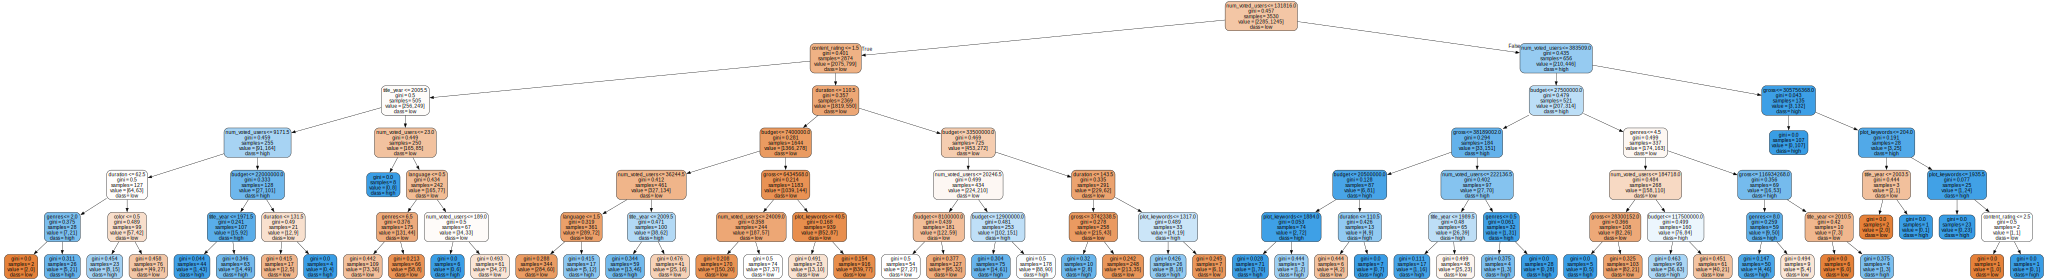

In [289]:
import graphviz

# Plotting the decision tree for the best estimator 
dot_data = export_graphviz(best, out_file=None,
               feature_names=X.columns,  # feature names from dataset
               filled=True, 
               rounded=True, 
               class_names=['low', 'high'])  # classification labels 
               
graph = graphviz.Source(dot_data)
graph

#14 View the results, comment on how the model performed using the metrics you selected

In [290]:
print(model.cv_results_)

{'mean_fit_time': array([0.00630588, 0.01033882, 0.01647902, 0.01839204, 0.02469675,
       0.02475582, 0.02946883, 0.03133879, 0.03516431, 0.0366713 ,
       0.03914052]), 'std_fit_time': array([0.00201748, 0.00325489, 0.00615291, 0.00609924, 0.00938138,
       0.00783433, 0.00756854, 0.00707861, 0.009571  , 0.00817699,
       0.00908832]), 'mean_score_time': array([0.00855366, 0.01103003, 0.01311852, 0.01301716, 0.01320001,
       0.01111412, 0.0104153 , 0.01060907, 0.01170433, 0.01142502,
       0.01071414]), 'std_score_time': array([0.00191954, 0.0043461 , 0.00673106, 0.00861797, 0.00675933,
       0.00387398, 0.00443913, 0.00431125, 0.00503916, 0.00415465,
       0.00522908]), 'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 1}, {'max_depth': 2}, {'max_depth': 3}, {'ma

In [291]:
print(model.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'split5_test_roc_auc', 'split6_test_roc_auc', 'split7_test_roc_auc', 'split8_test_roc_auc', 'split9_test_roc_auc', 'split10_test_roc_auc', 'split11_test_roc_auc', 'split12_test_roc_auc', 'split13_test_roc_auc', 'split14_test_roc_auc', 'split15_test_roc_auc', 'split16_test_roc_auc', 'split17_test_roc_auc', 'split18_test_roc_auc', 'split19_test_roc_auc', 'split20_test_roc_auc', 'split21_test_roc_auc', 'split22_test_roc_auc', 'split23_test_roc_auc', 'split24_test_roc_auc', 'split25_test_roc_auc', 'split26_test_roc_auc', 'split27_test_roc_auc', 'split28_test_roc_auc', 'split29_test_roc_auc', 'split30_test_roc_auc', 'split31_test_roc_auc', 'split32_test_roc_auc', 'split33_test_roc_auc', 'split34_test_roc_auc', 'split35_test_roc_auc', 'split36_test_roc_auc', 'split37_tes

In [292]:
#Scores: 

auc = model.cv_results_['mean_test_roc_auc']
recall= model.cv_results_['mean_test_recall']
bal_acc= model.cv_results_['mean_test_balanced_accuracy']

SDauc = model.cv_results_['std_test_roc_auc']
SDrecall= model.cv_results_['std_test_recall']
SDbal_acc= model.cv_results_['std_test_balanced_accuracy']

#Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,SDauc,SDrecall,SDbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

final_model.style.hide(axis='index')

depth,auc,recall,bal_acc,aucSD,recallSD,bal_accSD
1,0.619225,0.320639,0.619225,0.020605,0.052963,0.020605
2,0.679502,0.384270,0.632795,0.021626,0.076876,0.022045
3,0.716851,0.396333,0.653880,0.027491,0.059423,0.024304
4,0.748679,0.456392,0.671259,0.025296,0.082657,0.027002
5,0.768921,0.494351,0.687008,0.021632,0.064208,0.020700
6,0.784486,0.549690,0.710290,0.019385,0.058501,0.021583
7,0.783897,0.558366,0.716159,0.025926,0.055470,0.026199
8,0.775100,0.561430,0.717779,0.027651,0.049974,0.023592
9,0.764954,0.585036,0.724946,0.030610,0.042096,0.022764
10,0.747721,0.601738,0.728833,0.029121,0.043379,0.021335


The decision tree model had its highest AUC of 0.7844 at depth 6. Recall and balanced accuracy improved with tree depth, however, performance gains did not improve significantly after depth 6, indicating that deeper trees may not generalize better. Depth 6 offers the best balance between accuracy, recall, without running the risk of overfitting. 

#15 Which variables appear to be contributing the most (variable importance) 

In [293]:
#Variable importance for the best estimator
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

                 importance
num_voted_users    0.460593
budget             0.155548
duration           0.097530
content_rating     0.088920
title_year         0.064745
gross              0.048942
genres             0.036917
language           0.022795
plot_keywords      0.019212
color              0.004800
country            0.000000


#16 Use the predict method on the tune data and print out the results.

In [294]:
# Use the best estimator from GridSearchCV to make predictions on the tune set
tune_predictions = best.predict(X_tune)

# Print the predictions
print(tune_predictions)


[0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0
 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1
 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1
 1 0 0 0 0 0 1 0 1 0 1 0 

#17 How does the model perform on the tune data?

In [295]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
tune_preds = best.predict(X_tune)
tune_probs = best.predict_proba(X_tune)[:, 1]  # for ROC AUC

# Accuracy
acc = accuracy_score(y_tune, tune_preds)
print(f"Accuracy: {acc:.4f}")

# ROC AUC
auc = roc_auc_score(y_tune, tune_probs)
print(f"ROC AUC: {auc:.4f}")

# Full classification report
print("\nClassification Report:")
print(classification_report(y_tune, tune_preds, target_names=['low', 'high']))

Accuracy: 0.7540
ROC AUC: 0.7960

Classification Report:
              precision    recall  f1-score   support

         low       0.78      0.87      0.82       490
        high       0.70      0.53      0.60       266

    accuracy                           0.75       756
   macro avg       0.74      0.70      0.71       756
weighted avg       0.75      0.75      0.75       756



The model is overall solid with 76% accuracy and good AUC, and it does a strong job predicting low-rated movies. However, recall is low for high-rated movies, meaning it misses many high-rated ones. It may be biased toward the majority class (low-rated) due to imbalance in the data.

#18 Print out the confusion matrix for the tune data, what does it tell you about the model?

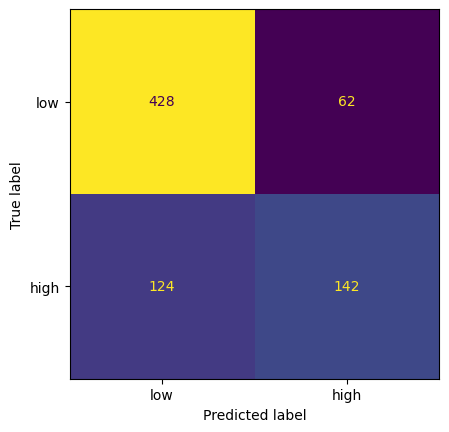

In [296]:
print(ConfusionMatrixDisplay.from_estimator(best,X_tune,y_tune, display_labels = ['low','high'], colorbar=False))

The confusion matrix visualizes the metrics, further showing how recall is low. More high-rated movies are falsely predicted as having a low rating than there are high-rated movies correctly predicted as having a high rating. This heavily contradicts the low rated true positives and negatives which have a much stronger ratio.

#19 What are the top 3 movies based on the tune set? Which variables are most important in predicting the top 3 movies?

In [297]:
X_tune["predicted_rating"] = tune_preds
top_movies = X_tune.sort_values("predicted_rating", ascending=False).head(3)
print(top_movies)

top_movie_indices = top_movies.index  

top_movie_titles = movie_titles.loc[top_movie_indices, "movie_title"]
top_movie_titles = top_movie_titles.str.strip()

print("Top 3 Movies:")
print(top_movie_titles.tolist())

      color  duration        gross  genres  num_voted_users  plot_keywords  \
1541      1     123.0  104632573.0       7            63839            774   
4412      1     110.0    2365931.0       4            36657           2049   
3674      1     111.0    6200756.0       4            96129            380   

      language  country  content_rating      budget  title_year  \
1541         0        4               2  32000000.0      1996.0   
4412         0        4               4   1500000.0      1998.0   
3674         0        4               4   7000000.0      2001.0   

      predicted_rating  
1541                 1  
4412                 1  
3674                 1  
Top 3 Movies:
['Phenomenon', "Buffalo '66", 'Ghost World']


#20 Use a different hyperparameter for the grid search function and go through the process above again using the tune set.

In [298]:
param2 = {'min_samples_split': [2, 5, 10, 20]} # will predict which number would produce the best model based on how many samples should be required for a split
cl2= DecisionTreeClassifier(random_state=1000)
search = GridSearchCV(cl2, param2, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc')
model2 = search.fit(X_tune, y_tune)
cl2.fit(X_tune, y_tune)
best2 = model2.best_estimator_
print("Best min_samples_split:", model2.best_params_['min_samples_split'])
print("Best ROC AUC Score:", model2.best_score_)

print(model2.cv_results_)

# Extract the scores
auc2 = model2.cv_results_['mean_test_roc_auc']
recall2 = model2.cv_results_['mean_test_recall']
bal_acc2 = model2.cv_results_['mean_test_balanced_accuracy']

SDauc2 = model2.cv_results_['std_test_roc_auc']
SDrecall2 = model2.cv_results_['std_test_recall']
SDbal_acc2 = model2.cv_results_['std_test_balanced_accuracy']

# Extract the tested values of min_samples_split
min_split_vals = [d['min_samples_split'] for d in model2.cv_results_['params']]

# Build the df
final_model2 = pd.DataFrame(list(zip(min_split_vals, auc2, recall2, bal_acc2, SDauc2, SDrecall2, SDbal_acc2)),
                            columns=['min_split', 'auc', 'recall', 'bal_acc', 'aucSD', 'recallSD', 'bal_accSD'])

final_model2.style.hide(axis='index')







Best min_samples_split: 20
Best ROC AUC Score: 0.741241932670504
{'mean_fit_time': array([0.01494027, 0.01240819, 0.01051456, 0.0108613 ]), 'std_fit_time': array([0.01390715, 0.00887975, 0.0050231 , 0.00632628]), 'mean_score_time': array([0.01087996, 0.01866721, 0.0121292 , 0.01104504]), 'std_score_time': array([0.00715227, 0.01813044, 0.00648397, 0.00700444]), 'param_min_samples_split': masked_array(data=[2, 5, 10, 20],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_samples_split': 2}, {'min_samples_split': 5}, {'min_samples_split': 10}, {'min_samples_split': 20}], 'split0_test_roc_auc': array([0.74981104, 0.75812547, 0.80990174, 0.80574452]), 'split1_test_roc_auc': array([0.67573696, 0.74565382, 0.73431595, 0.84126984]), 'split2_test_roc_auc': array([0.63492063, 0.69123205, 0.68820862, 0.74867725]), 'split3_test_roc_auc': array([0.66364324, 0.67082389, 0.69992441, 0.78080121]), 'split4_test_roc_auc': array([0.6738473

min_split,auc,recall,bal_acc,aucSD,recallSD,bal_accSD
2,0.672910,0.581738,0.672910,0.062362,0.113647,0.062362
5,0.686346,0.567521,0.672332,0.059634,0.104548,0.060357
10,0.709970,0.564644,0.670893,0.057798,0.099199,0.055999
20,0.741242,0.550228,0.673073,0.059478,0.092848,0.048121


#21 Did the model improve with the new hyperparameter search?

No, the model showed a decrease in performance across all cross-validation metrics compared to the max depth parameter search. 

#22 Using the better model, predict the test data and print out the results.

In [299]:
test_predictions = best.predict(X_test)

test_preds = best.predict(X_test)
test_probs = best.predict_proba(X_test)[:, 1]  # for ROC AUC

# Accuracy
acctest = accuracy_score(y_test, test_preds)
print(f"Accuracy: {acc:.4f}")

# ROC AUC
auctest = roc_auc_score(y_test, test_probs)
print(f"ROC AUC: {auctest:.4f}") 

# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, test_preds, target_names=['low', 'high']))



Accuracy: 0.7540
ROC AUC: 0.7758

Classification Report:
              precision    recall  f1-score   support

         low       0.78      0.85      0.82       490
        high       0.68      0.57      0.62       267

    accuracy                           0.75       757
   macro avg       0.73      0.71      0.72       757
weighted avg       0.75      0.75      0.75       757



#23 Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.

Throughout building and analyzing DT models, I learned that decision trees can be a powerful but sensitive tool for classification, especially when working with complex data with a lot of variables factoring into the target variable. I realized how important it is to tune the model’s parameters to avoid overfitting and get more balanced and accurate predictions. I also learned how complicated decision trees can be, and that they are require some deciphering and a critical eye. Using evaluation tools like ROC AUC and confusion matrices helped me understand not just how accurate the model was, but also where it struggled, like favoring one class over another. Overall, I gained a better understanding of how machine learning models need to be both tested and interpreted carefully, and that even simple models require thoughtful tuning to perform well in practice. 

Based on these insights, I recommend using this model as a first test classifier to flag movies that are likely to receive low ratings and for general pattern exploration. However, the model should be tuned carefully to avoid overfitting, and results should be interpreted by humans to ensure it is performing with high accuracy and reliability. It could also be of more practical use if some of the variables are tweaked to be more meaningful in a classification model. For example, plot keywords could be of great variable importance if it is categorized and reentered for stronger interpretability. Overall, decision tree models should be used to support early predictions that can contribute to interventions in marketing strategies, but should not be the sole factor used in evaluating a movie’s potential.